# Table of Contents

* [Pipelines](#pipelines)
    * [Why should I use them?](#whypipelines)
    * [Example](#pipeexample)
    * [Adding Steps](#addingsteps)
* [Types of Classification](#classtypes)
    * [Binary Classification](#binary)
        * [Dataset for Binary Classification](#datasetbinary)
        * [Data Density](#densitybinary)
        * [Train Test Split](#splitbinary)
        * [Baseline for Comparison](#baselinebinary)
        * [K-Fold Crossvalidation](#kfold)
        * [Description of Algorithms](#description)
        * [Running the baseline](#runningbinary)
        * [Scaling the dataset](#scalingbinary)
        * [Tuning an SVM model](#tuningSVM)
        * [Testing our Models](#testingbinary)
    * [Multiclass Classification](#multiclass)
        * [Dataset for Multiclass Classification](#datasetmulti)
        * [Data Density](#densitymulti)
        * [Train Test Split](#splitmulti)
        * [Baseline for Comparison](#baselinemulti)
        * [Scaling the dataset](#scalingmulti)
        * [Running the Baseline](#runningmulti)
        * [Testing our Models](#testingmulti)

# sci-kit learn's Pipelines <a class=anchor id='pipelines'>

One useful feature that sci-kit learn has is the ability to chain together several operations that are cross-validated while setting different parameters. Each intermediate step in the pipeline is a transform, which may [clean](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing), [reduce](http://scikit-learn.org/stable/modules/unsupervised_reduction.html#data-reduction), [expand](http://scikit-learn.org/stable/modules/kernel_approximation.html#kernel-approximation), or [generate](http://scikit-learn.org/stable/modules/feature_extraction.html#feature-extraction) feature representations and must implement both `fit()` and `transform()` methods. The final step of the pipeline is an estimator, which can perform classification, regression, or clustering and only needs to call `fit()`.

## Why should I use them? <a class=anchor id='whypipelines'>

### Ease 
You only need to call `fit` and `predict` once on your data to fit a sequence of estimators.

### Parameter selection
You can [grid search](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) over parameters of all estimators in one step.

### Safety
Because Pipelines use cross-validation, data leakage is minimized.

## Example <a class = anchor id='pipeexample'>

In this example we will generate some synthetic data using sklearn's `make_blobs()` and plot the result to see what the data looks like.

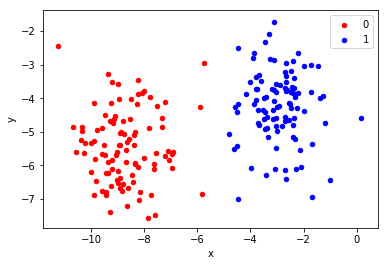

In [1]:
from sklearn.datasets.samples_generator import make_blobs
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_blobs(n_samples=200, centers = 2, n_features = 2) 
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

Once our data has been generated, we can create a Pipeline to scale and train our model.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train_example, X_test_example, y_train_example, y_test_example = train_test_split(X, y, test_size=0.2, random_state=0)

clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X_train_example, y_train_example)
pred_test = clf.predict(X_test_example)

print('{:.2%}\n'.format(accuracy_score(y_test_example, pred_test)))

100.00%



An accuracy score of 90% would normally be suspect, but since we are using a very small synthetic dataset with only two features, it's not really surprising that the accuracy would be as high as it is. We can add more steps to our Pipeline without sacrificing code readability.

### Adding Steps to a Pipeline <a class=anchor id='addingsteps'>


Since Pipelines work similarly to lists, we can add (and remove) steps from the Pipeline using the `.steps.append()` to append a step at the end of our Pipeline, or `.steps.insert()` to insert a step at a given position. If we want to remove a step, we can use the `.steps.pop(n)` to remove steps.

# Types of Classification <a class = anchor id='classtypes'>

## Binary Classification <a class=anchor id='binary'>

In binary classification, the goal is to predict between two possible class labels, predicting if an e-mail is spam or ham, would be an example of binary classification.

### Dataset for Binary Classification <a class=anchor id='datasetbinary'>

The dataset we will be using for this example is the Wisconsin Breast Cancer dataset. Like the Boston Housing Prices dataset from the regression meeting, this dataset can be loaded from sci-kit learn using `load_breast_cancer()` function from sci-kit learn's datasets package.

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer_data = load_breast_cancer()

Now that have the dataset loaded from sci-kit learn, let's use pandas to get more information about the dataset.

In [ ]:
import pandas as pd
import numpy as np

cancer_df = pd.DataFrame(data=cancer_data.data, columns=cancer_data.feature_names)
cancer_df['target'] = cancer_data['target']
cancer_df.head()

We can see the data printed above, but that doesn't tell us very much about what the columns of data represent. Included in the data is the `DESCR` attribute, which when printed will give us a nicely formatted description of the columns of data in our dataset.

In [ ]:
print(cancer_data.DESCR)

In [ ]:
print(cancer_df.groupby('target').size())

### Data Density <a class=anchor id='densitybinary'>

We can visualize the density of the data to get a sense of the distribution of the data. Knowing the distribution of the data can be helpful in selecting classification algorithms. This plot shows a generally Gaussian or normal distribution of the data.

In [ ]:
cancer_df.plot(kind='density', subplots=True, layout=(5,7), sharex=False, legend=False, fontsize=1)
plt.show()

### Train Test Split <a class=anchor id='splitbinary'>

Before we perform any cool machine learning functions with our data we need to make sure that it is split into smaller subsets, to guard against data "leaking" through and biasing our results. We will use sklearn's built in `train_test_split` function in `model_selection`.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, cancer_data.target, test_size=0.2, random_state=0)

### Baseline Comparison <a class=anchor id='baselinebinary'>

Before applying any kind of pre-processing to the data, we should check what performance we are able to achieve without any additional work.

#### K-Fold Cross-Validation <a class=anchor id='kfold'>

In this example we are using 10-fold cross-validation (K = 10 in this case). This will split our set into 10 separate "pieces", with a different "piece" held out during each run. More information can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
import time

#### Description of Algorithms <a class=anchor id='description'>

##### K-Nearest Neighbors: 

In KNN, class membership is determined by examining the class membership of the K (default is 5 in sklearn) closest points to the data point in question. More information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and [here](http://scikit-learn.org/stable/modules/neighbors.html).

##### Support Vector Classifier:

Support Vector Machines seek to make data linearly separable, so that classification decisions can be made. The use of different kernel functions allows the SVM flexibility when different shapes of data are present. More information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) and [here](http://scikit-learn.org/stable/modules/svm.html). 

##### Decision Tree:

Decision Trees work by learning simple decision rules inferred from the data features. Each feature is split into yes/no questions for values above or below a certain value or presence/absence of a given feature. More information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) or [here](http://scikit-learn.org/stable/modules/tree.html).

##### Gaussian Naive Bayes:

Gaussian Naive Bayes works by applying [Bayes Theorem](https://plato.stanford.edu/entries/bayes-theorem/) with strong (naive) assumptions about feature independence. We are using the Gaussian version since our data has a Gaussian distribution. More information can be found [here](http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes). 

##### Logistic Regression: 

Logistic Regression, despite having regression in the name, is a linear model for classification. The equation for binary classification takes the form $\hat{y} = w[0] * x[0] + w[1] * x[1] + ... + w[n] * x[n] + b > 0$, if $\hat{y}$ is greater than 0 we predict the class +1, else -1. More information can be found [here](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

In [ ]:
model_list = []
model_list.append(('Tree', DecisionTreeClassifier()))
model_list.append(('SVC', SVC()))
model_list.append(('KNN', KNeighborsClassifier()))
model_list.append(('NB', GaussianNB()))
model_list.append(('LR', LogisticRegression()))

#### Running the Baseline <a class=anchor id='runningbinary'>

In [ ]:
num_folds = 10
results = []
names = []

for name, model in model_list:
    kfold = KFold(n_splits=num_folds, random_state=0)
    start = time.time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "{}: {:.5f} ({:.5f}) (run time: {:.5f})".format(name, cv_results.mean(), cv_results.std(), end-start))

### Scaling the Dataset <a class=anchor id='scalingbinary'>

With our baseline established, we can now look to see how applying a scaling factor to the dataset will affect the performance of the dataset. We will use pipelines to standardize the data and fit the model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipelines = []
pipelines.append(('ScaledTree', Pipeline([('Scaler', StandardScaler()), ('Tree', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))

In [ ]:
results = []
names = []

for name, model in pipelines:
    start = time.time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( '{}: {:.5f} ({:.5f}) (run time: {:.5f})'.format(name, cv_results.mean(), cv_results.std(), end-start))

### Tuning a SVM Model <a class=anchor id='tuningSVM'>

While we have achieved fairly high accuracy on the training set already, we can usually squeeze more performance out of a particular algorithm by tuning the hyperparameters of the algorithm. In this case we will use `GridSearchCV` and test different values of the parameter `C` along with the `kernel` hyperparameter.

In [ ]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

Here we are specifying the values of `C` and the `kernel` that we would like to iterate over when we are doing our `GridSearchCV`. We then create a Python `dict` to create a grid that can be iterated over.

In [ ]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

Next, we create the `Support Vector Classifier` object and the `KFold` object, along with the `GridSearchCV` object. We will pass the scaled `X_train` dataset and the unscaled target values. We can get the best results using the `best_score_` and `best_params_` attributes of `GridSearchCV`. We can then print this, along with mean, standard deviation and parameter value from each combination.

In [ ]:
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: {:.5f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.5f} ({:.5f}) with: {}".format(mean, stdev, param))

### Testing Our Models <a class=anchor id='testingbinary'>

Now that we have improved our model's performance on the training set, we should look at how well both our baseline models and our tuned SVM model does on our testing set. Since we scaled our training data, we need to apply the same scaling to our testing data.

In [ ]:
X_test_scaled = scaler.transform(X_test)

We will use the same algorithms for the testing that we used in establishing our baseline. Since we used default parameters for the baseline, we will use them for testing as well.

In [ ]:
model_tree = DecisionTreeClassifier().fit(rescaledX, y_train)
model_knn = KNeighborsClassifier().fit(rescaledX, y_train)
model_NB = GaussianNB().fit(rescaledX, y_train)
model_LR = LogisticRegression().fit(rescaledX, y_train)

print('Accuracy score: Tree: {:.5f}'. format(accuracy_score(model_tree.predict(X_test_scaled), y_test)))
print('Accuracy score: KNN: {:.5f}'. format(accuracy_score(model_knn.predict(X_test_scaled), y_test)))
print('Accuracy score: GaussianNB: {:.5f}'. format(accuracy_score(model_NB.predict(X_test_scaled), y_test)))
print('Accuracy score: LR: {:.5f}'. format(accuracy_score(model_LR.predict(X_test_scaled), y_test)))

We can create our SVM model using the best values from our use of `GridSearchCV`. Using this model we can test to see how well it performs on our test data. From here we can decide to use that model or select a new one.

In [ ]:
model_svc = SVC(C= 0.5, kernel='linear')

model_svc.fit(rescaledX, y_train)

predictions = model_svc.predict(X_test_scaled)
print('Accuracy score: {:.5f}'.format(accuracy_score(predictions, y_test)))

## Multiclass Classification <a class=anchor id='multiclass'>

Multiclass classification, on the other hand, the goal is to predict possible class labels on more than two possible class labels.

### Dataset for Multiclass Classification <a class=anchor id='datasetmulti'>

The dataset we will be using for the multiclass example is UCL Wine dataset, the goal of the dataset is to predict which cultivar a sample of wine is from.

In [ ]:
from sklearn.datasets import load_wine

wine_data = load_wine()

Much like the Binary Classification example, we will load the wine dataset into a pandas `DataFrame` so that we can get a better look at the data in question.

In [ ]:
wine_df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
wine_df['target'] = wine_data['target']
wine_df.head()

Again, like our earlier dataset, we can use the `DESCR` attribute of the dataset to get more information about the dataset without having to look it up on an external website.

In [ ]:
print(wine_data.DESCR)

### Data Density <a class=anchor id='densitymulti'>

We can visualize the density of the data to get a sense of the distribution of the data. Knowing the distribution of the data can be helpful in selecting classification algorithms. This plot shows a generally Gaussian or normal distribution of the data.

In [ ]:
wine_df.plot(kind='density', subplots=True, layout=(5,7), sharex=False, legend=False, fontsize=1)
plt.show()

## Train Test Split <a class=anchor id='splitmulti'>

In [ ]:
from sklearn.model_selection import train_test_split

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(wine_data.data, wine_data.target, 
                                                                        test_size=0.3, random_state=0)

## Baseline for Comparison <a class=anchor id='baselinemulti'>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
import time

In [ ]:
model_list = []
model_list.append(('Tree', DecisionTreeClassifier()))
model_list.append(('SVC', SVC()))
model_list.append(('KNN', KNeighborsClassifier()))
model_list.append(('NB', GaussianNB()))
model_list.append(('LR', LogisticRegression()))

### Running the Baseline <a class=anchor id='runningmulti'>

In [ ]:
num_folds = 10
results = []
names = []

for name, model in model_list:
    kfold = KFold(n_splits=num_folds, random_state=0)
    start = time.time()
    cv_results = cross_val_score(model, X_train_wine, y_train_wine, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "{}: {:.5f} ({:.5f}) (run time: {:.5f})".format(name, cv_results.mean(), cv_results.std(), end-start))

### Scaling the Dataset <a class=anchor id='scalingmulti'>

With our baseline established, we can now look to see how applying a scaling factor to the dataset will affect the performance of the dataset. We will use pipelines to standardize the data and fit the model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipelines = []
pipelines.append(('ScaledTree', Pipeline([('Scaler', StandardScaler()), ('Tree', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))

In [ ]:
results = []
names = []

for name, model in pipelines:
    start = time.time()
    cv_results = cross_val_score(model, X_train_wine, y_train_wine, cv=kfold, scoring='accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "{}: {:.5f} ({:.5f}) (run time: {:.5f})".format(name, cv_results.mean(), cv_results.std(), end-start))

### Testing our Models <a class=anchor id='testingmulti'>

Given that our models all perform reasonably well on our data and since we just did an example on tuning an SVM, we can go ahead and see how well our models perform on the test data. 

In [ ]:
scaler = StandardScaler().fit(X_train_wine)
rescaledX_wine = scaler.transform(X_train_wine)
X_test_scaled_wine = scaler.transform(X_test_wine)

model_tree = DecisionTreeClassifier().fit(rescaledX_wine, y_train_wine)
model_knn = KNeighborsClassifier().fit(rescaledX_wine, y_train_wine)
model_NB = GaussianNB().fit(rescaledX_wine, y_train_wine)
model_LR = LogisticRegression().fit(rescaledX_wine, y_train_wine)
model_SVC = SVC().fit(rescaledX_wine, y_train_wine)

print('Accuracy score: Tree: {:.5f}'. format(accuracy_score(model_tree.predict(X_test_scaled_wine), y_test_wine)))
print('Accuracy score: SVM: {:.5f}'. format(accuracy_score(model_SVC.predict(X_test_scaled_wine), y_test_wine)))
print('Accuracy score: KNN: {:.5f}'. format(accuracy_score(model_knn.predict(X_test_scaled_wine), y_test_wine)))
print('Accuracy score: GaussianNB: {:.5f}'. format(accuracy_score(model_NB.predict(X_test_scaled_wine), y_test_wine)))
print('Accuracy score: LR: {:.5f}'. format(accuracy_score(model_LR.predict(X_test_scaled_wine), y_test_wine)))